# Positional Derivatives

In this notebook we explain how to use the derivatives w.r.t. the position (instead of w.r.t. the control, as was done in previous notebooks). The reason we look into this is because positional derivatives are required by the OED optimization problem in order to include limitations onto the flight path (houses, edge of domain, etc.).

## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from InverseProblem import InverseProblem
from FOM_stationary import FOM_stationary as FOM
from OEDUtility import OEDUtility
from Drone import Drone as Drone

from DetectorPointwise import DetectorPointwise
from DetectorUniform import DetectorUniform
from DetectorGaussian import DetectorGaussian
from DetectorTruncGaussian import DetectorTruncGaussian
from Navigation import Navigation as Navigation

import time
tStart_notebook = time.time()

## User settings

In [2]:
centers = [[0.4, 0.6], [0.6, 0.4]]
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_test_2d = 100  # resolution for 2D plots (50: ~1 min runtime for dt = 0.01)

sigma = 0.05  # std deviation for gaussian-type measurements. Get pointwise data for sigma -> 0
radius = 0.05  # truncation radius for truncation-style measurements

meshDim = 200  # discretization parameter (1D) for FOM
meshDim_drone = 10  # discretization parameter (1D) for subdomain in truncation-type measurements

dt = 0.01

## Setup

We use the same model setup as in the previous notebook, except for the navigation:

In [3]:
# initialize full-order model
tStart = time.time()
fom = FOM(meshDim = meshDim, centers=centers)
print("Runtime of this block: {} s".format(time.time()-tStart))
n_para = fom.n_para

# compute one solution for nicer visualization below
para_true = np.ones((n_para,))
state = fom.solve(parameter=para_true)

# set a prior
prior_mean = np.zeros((n_para,))
prior_covar = var_prior*np.eye(n_para)
fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

Runtime of this block: 36.62577509880066 s


## Testing positional derivatives

Since our goal in this notebook is to look at the derivatives w.r.t. the position, looking at a "complicated" geometry like a circle is going to make our life difficult. Instead, let's look at a very easy flightpath: Going straight from A to B to C:

In [4]:
class NavigationABC(Navigation):
    
    def __init__(self):
        grid_t = np.array([0, dt, 2*dt])
        super().__init__(grid_t = grid_t)
        
    def get_trajectory(self, alpha, grid_t=None):
        return alpha, self.grid_t

For convenience, we use point-wise measurements:

In [5]:
# drone setup
navigation = NavigationABC()
detector = DetectorPointwise(fom)
drone = Drone(detector=detector, navigation=navigation)

# define inverse problem
inversion = InverseProblem(fom, drone)

# compute the states for the parameter basis
tStart = time.time()
inversion.compute_states(np.eye(n_para))
print("State solve time ({} parameters): {} s".format(n_para, time.time()-tStart))

# initialize object for computing the utility
utility = OEDUtility(inversion)

State solve time (2 parameters): 0.8806929588317871 s


Let's visualize this flight path:

Text(0.2, 0.6, 'C')

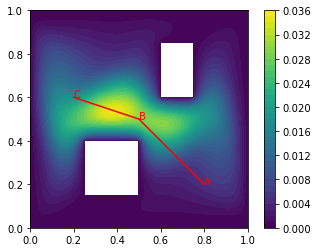

In [6]:
# user setting
alpha = np.array([[0.8,0.2], [0.5, 0.5], [0.2, 0.6]])  # set flight markers A-B-C

# compute flight
flight = drone.plan_flight(alpha=alpha)  # Flight object
flightpath, grid_t_drone = flight.flightpath, flight.grid_t  # path and its time discretization

fom.plot(state)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")

plt.annotate(text = "A", xy=(flightpath[0, 0], flightpath[0, 1]), color="r")
plt.annotate(text = "B", xy=(flightpath[1, 0], flightpath[1, 1]), color="r")
plt.annotate(text = "C", xy=(flightpath[2, 0], flightpath[2, 1]), color="r")

For our experiment, we keep the positions of `A` and `C` fixed, and vary `B` within an area.

In [7]:
xvals = np.linspace(0.3, 0.7, n_test_2d)
yvals = np.linspace(0.4, 0.6, n_test_2d+1)

util = np.zeros((3, n_test_2d, n_test_2d+1))
alpha = np.array([[0.8,0.2], [0.5, 0.5], [0.2, 0.6]])

for i in range(n_test_2d):
    for j in range(n_test_2d+1):
        alpha[1, 0] = xvals[i]
        alpha[1, 1] = yvals[j]
        posterior = inversion.compute_posterior(alpha=alpha)

        util[0, i, j] = utility.eval_utility(posterior, mode="A")
        util[1, i, j] = utility.eval_utility(posterior, mode="D")
        util[2, i, j] = utility.eval_utility(posterior, mode="E")

Text(0.5, 1.0, 'E-OED')

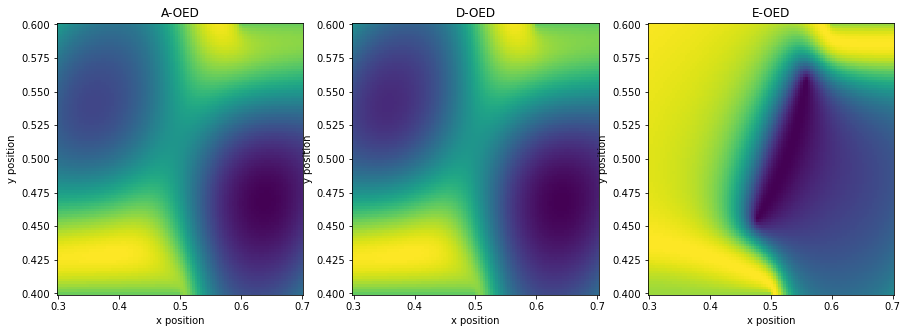

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i in range(3):
    axs[i].pcolormesh(xvals, yvals, util[i, :, :].T)
    axs[i].set_xlabel("x position")
    axs[i].set_ylabel("y position")

axs[0].set_title("A-OED")
axs[1].set_title("D-OED")
axs[2].set_title("E-OED")

Next we visualize the derivatives.

In [9]:
# user setting
x_test = 0.55
y_test = 0.5

# reference posterior
alpha_test = np.array([[0.8,0.2], [x_test, y_test], [0.2, 0.6]])
posterior_ref = inversion.compute_posterior(alpha=alpha_test)

util_ref = np.zeros(4)
print("Evaluating utility at reference")
util_ref[0] = utility.eval_utility(posterior_ref, mode="A")
util_ref[1] = utility.eval_utility(posterior_ref, mode="D")
util_ref[2] = utility.eval_utility(posterior_ref, mode="D-inverse")
util_ref[3] = utility.eval_utility(posterior_ref, mode="E")

print("Evaluating derivatives at reference")
tStart_sub = time.time()
der_ref_A = utility.d_utility_d_position(posterior_ref, mode="A")[[1,4]]
der_ref_D = utility.d_utility_d_position(posterior_ref, mode="D")[[1,4]]
der_ref_Dinv = utility.d_utility_d_position(posterior_ref, mode="D-inverse")[[1,4]]
print("mean time for taking derivativies: ", (time.time()-tStart_sub)/3, " s.")
## done with the important part

print("Starting to compute 1D plot points")
util_test = np.zeros((4, 2, n_test_2d+1))
for i in range(n_test_2d+1):
    #print("iteration {} / {}".format(i+1, n_test_2d+1))
    
    if i < n_test_2d:
        # vec_speed has one entry less (to avoid accidentally transposing the results)
        
        alpha[1, 0] = xvals[i]
        alpha[1, 1] = alpha_test[1, 1]
        
        posterior = inversion.compute_posterior(alpha=alpha)

        util_test[0, 0, i] = utility.eval_utility(posterior, mode="A")
        util_test[1, 0, i] = utility.eval_utility(posterior, mode="D")
        util_test[2, 0, i] = utility.eval_utility(posterior, mode="D-inverse")
        util_test[3, 0, i] = utility.eval_utility(posterior, mode="E")
        
    alpha[1, 0] = alpha_test[1, 0]
    alpha[1, 1] = yvals[i]
    posterior = inversion.compute_posterior(alpha=alpha)

    util_test[0, 1, i] = utility.eval_utility(posterior, mode="A")
    util_test[1, 1, i] = utility.eval_utility(posterior, mode="D")
    util_test[2, 1, i] = utility.eval_utility(posterior, mode="D-inverse")
    util_test[3, 0, i] = utility.eval_utility(posterior, mode="E")

Evaluating utility at reference
Evaluating derivatives at reference
mean time for taking derivativies:  0.9082926909128824  s.
Starting to compute 1D plot points


Text(0.5, 0, 'y position')

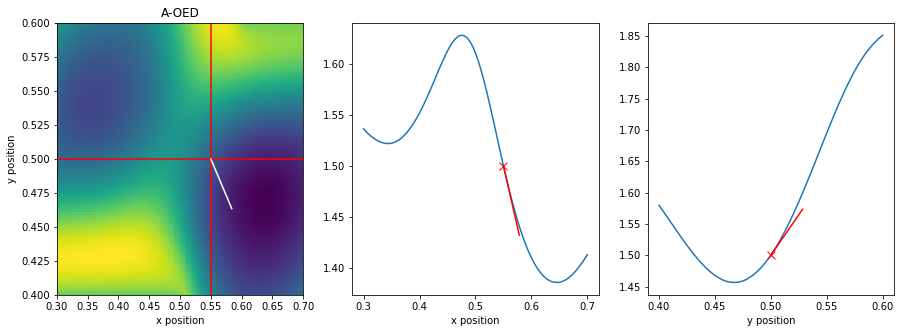

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
norm = la.norm(der_ref_A)
scale = 0.1/norm

axs[0].pcolormesh(xvals, yvals, util[0, :, :].T)
axs[0].plot([xvals[0], xvals[-1]], [y_test, y_test], color="r", marker=None)
axs[0].plot([x_test, x_test], [yvals[0], yvals[-1]], color="r", marker=None)
axs[0].plot([x_test, x_test - 0.5 * scale * der_ref_A[0]], 
            [y_test, y_test - 0.5 * scale * der_ref_A[1]], 
            color = "w", marker = None)
axs[0].set_xlabel("x position")
axs[0].set_ylabel("y position")
axs[0].set_xlim([np.min(xvals), np.max(xvals)])
axs[0].set_ylim([np.min(yvals), np.max(yvals)])
axs[0].set_title("A-OED")

axs[1].plot(xvals, util_test[0, 0, :-1])
axs[1].plot([x_test], util_ref[0], marker="x", markersize=8, color="r")
axs[1].plot([x_test, x_test + scale], 
            [util_ref[0], util_ref[0]+scale*der_ref_A[0]], 
            marker="", markersize=8, color="r")
axs[1].set_xlabel("x position")

axs[2].plot(yvals, util_test[0, 1, :])
axs[2].plot([y_test], util_ref[0], marker="x", markersize=8, color="r")
axs[2].plot([y_test, y_test + scale], 
            [util_ref[0], util_ref[0]+scale*der_ref_A[1]], 
            marker="", markersize=8, color="r")
axs[2].set_xlabel("y position")

Text(0.5, 0, 'y position')

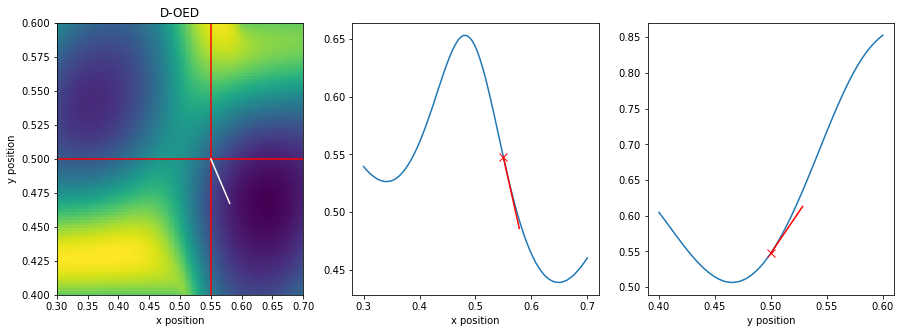

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
norm = la.norm(der_ref_A)
scale = 0.1/norm

axs[0].pcolormesh(xvals, yvals, util[1, :, :].T)
axs[0].plot([xvals[0], xvals[-1]], [y_test, y_test], color="r", marker=None)
axs[0].plot([x_test, x_test], [yvals[0], yvals[-1]], color="r", marker=None)
axs[0].plot([x_test, x_test - 0.5 * scale * der_ref_D[0]], 
            [y_test, y_test - 0.5 * scale * der_ref_D[1]], 
            color = "w", marker = None)
axs[0].set_xlabel("x position")
axs[0].set_ylabel("y position")
axs[0].set_xlim([np.min(xvals), np.max(xvals)])
axs[0].set_ylim([np.min(yvals), np.max(yvals)])
axs[0].set_title("D-OED")

axs[1].plot(xvals, util_test[1, 0, :-1])
axs[1].plot([x_test], util_ref[1], marker="x", markersize=8, color="r")
axs[1].plot([x_test, x_test + scale], 
            [util_ref[1], util_ref[1]+scale*der_ref_D[0]], 
            marker="", markersize=8, color="r")
axs[1].set_xlabel("x position")

axs[2].plot(yvals, util_test[1, 1, :])
axs[2].plot([y_test], util_ref[1], marker="x", markersize=8, color="r")
axs[2].plot([y_test, y_test + scale], 
            [util_ref[1], util_ref[1]+scale*der_ref_D[1]], 
            marker="", markersize=8, color="r")
axs[2].set_xlabel("y position")

**Note on `dt`:**
The behavior of the objective function changes a lot for different `dt`. That's because we are integrating here only over 3 time steps, so changing `dt` means we change over which time frame we measure and hence how much weight to even give to this data. When we have a fixed time frame s.t. decreasing `dt` leads to more individual measurements, this behavior should disappear.

Finite difference approximation

In [12]:
h = 0.00001
der_A_FD = np.zeros(2)
der_D_FD = np.zeros(2)

# x-direction
alpha_test = np.array([[0.8,0.2], [x_test + h, y_test], [0.2, 0.6]])
posterior = inversion.compute_posterior(alpha=alpha_test)

der_A_FD[0] = (utility.eval_utility(posterior, mode="A") - util_ref[0]) / h
der_D_FD[0] = (utility.eval_utility(posterior, mode="D") - util_ref[1]) / h

# y-direction
alpha_test = np.array([[0.8,0.2], [x_test, y_test+h], [0.2, 0.6]])
posterior = inversion.compute_posterior(alpha=alpha_test)

der_A_FD[1] = (utility.eval_utility(posterior, mode="A") - util_ref[0]) / h
der_D_FD[1] = (utility.eval_utility(posterior, mode="D") - util_ref[1]) / h

In [13]:
der_ref_A
# array([-2.41956053,  2.56494079])  # for meshDim = 100

array([-2.40365964,  2.58213775])

In [14]:
der_A_FD
# array([-2.53339374,  2.29403126])  # for meshDim = 100, h = 0.00001

array([-2.27483951,  2.64402162])

In [15]:
der_ref_D
# array([-2.18196022,  2.29295302])  # for meshDim = 100

array([-2.16958298,  2.30862512])

In [16]:
der_D_FD
# array([-2.27792866,  2.06066632])  # for meshDim = 100, h = 0.00001

array([-2.05738761,  2.36091939])

## The End.

In [17]:
runtime_notebook = time.time()-tStart_notebook
print("Runtime of this notebook: {} min".format(runtime_notebook / 60))

Runtime of this notebook: 0.7864086190859477 min
